# Zipline Pipeline

### Introduction

On any given trading day, the entire universe of stocks consists of thousands of securities. Usually, you will not be  interested in investing in all the stocks in the entire universe, but rather, you will likely select only a subset of these to invest. For example, you may only want to invest in stocks that have a 10-day average closing price of \$10.00 or less. Or you may only want to invest in the top 500 securities ranked by some factor.

In order to avoid spending a lot of time doing data wrangling to select only the securities you are interested in, people often use **pipelines**. In general, a pipeline is a placeholder for a series of data operations used to filter and rank data according to some factor or factors. 

In this notebook, you will learn how to work with the **Zipline Pipeline**. Zipline is an open-source algorithmic trading simulator developed by *Quantopian*. We will learn how to use the Zipline Pipeline to filter stock data according to factors. 

# Loading Data with Zipline

Before we build our pipeline with Zipline, we will first see how we can load the stock data we are going to use into Zipline. Zipline uses **Data Bundles** to make it easy to use different data sources. A data bundle is a collection of pricing data, adjustment data, and an asset database. Zipline employs data bundles to preload data used to run backtests and store data for future runs. Zipline comes with a few data bundles by default but it also has the ability to ingest new bundles. The first step to using a data bundle is to ingest the data. Zipline's ingestion process will start by downloading the data or by loading data files from your local machine. It will then pass the data to a set of writer objects that converts the original data to Zipline’s internal format (`bcolz` for pricing data, and `SQLite` for split/merger/dividend data) that hs been optimized for speed. This new data is written to a standard location that Zipline can find. By default, the new data is written to a subdirectory of `ZIPLINE_ROOT/data/<bundle>`, where `<bundle>` is the name given to the bundle ingested and the subdirectory is named with the current date. This allows Zipline to look at older data and run backtests on older copies of the data. Running a backtest with an old ingestion makes it easier to reproduce backtest results later. 

In this notebook, we will be using stock data from **Quotemedia**. In the Udacity Workspace you will find that the stock data from Quotemedia has already been ingested into Zipline. Therefore, in the code below we will use Zipline's `bundles.load()` function to load our previously ingested stock data from Quotemedia. In order to use the `bundles.load()` function we first need to do a couple of things. First, we need to specify the name of the bundle previously ingested. In this case, the name of the Quotemedia data bundle is `eod-quotemedia`:

In [27]:
import pandas as pd
import yfinance as yf
import tqdm
import logging
import os

# Set up logging to capture errors
logging.basicConfig(filename='download_errors.log', level=logging.ERROR)

# Load CSV data
df = pd.read_csv('https://raw.githubusercontent.com/rbpal/01-qt-project-03-smart-beta-portfolio-optimization/main/eod-quotemedia.csv', index_col=False)

# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Define output directory
output_dir = '../Data/data/eod-quotemedia/daily'
os.makedirs(output_dir, exist_ok=True)

# Group by ticker and process each group
for ticker, group in tqdm.tqdm(df.groupby('ticker')):
    # Ensure 'date' is sorted and in datetime format
    group = group.sort_values('date')
    
    # Get the start and end dates for this ticker
    start_session = pd.Timestamp('2013-07-01', tz='UTC')
    end_session = pd.Timestamp('2017-06-30', tz='UTC')
    
    try:
        # Download data from yfinance
        dat = yf.download(ticker, start=start_session, end=end_session, progress=False)
        
        # Check if data is returned
        if dat.empty:
            print(f"No data returned for {ticker}.")
            continue

        # Rename columns to match expected format
        dat.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
        
        # Rename index and ensure it's in datetime format
        dat.index.name = 'date'
        dat.index = dat.index.tz_localize(None)  # Remove timezone if needed
        
        # Write data to a CSV file with the ticker name
        dat.to_csv(f'{output_dir}/{ticker}.csv', index=True)

    except Exception as e:
        # Log and print errors
        print(f"Error processing {ticker}: {e}")
        logging.error(f"Error processing {ticker}: {e}")

    # Break statement is for debugging; remove in production
    break


  0%|          | 0/495 [00:00<?, ?it/s]


Second, we need to register the data bundle and its ingest function with Zipline, using the `bundles.register()` function. The ingest function is responsible for loading the data into memory and passing it to a set of writer objects provided by Zipline to convert the data to Zipline’s internal format. Since the original Quotemedia data was contained in `.csv` files, we will use the `csvdir_equities()` function to generate the ingest function for our Quotemedia data bundle. In addition, since Quotemedia's `.csv` files contained daily stock data, we will set the time frame for our ingest function, to `daily`.

In [1]:
import pandas as pd
from zipline.data.bundles import register, ingest
from zipline.data.bundles.csvdir import csvdir_equities
import logging

# Set up logging to capture errors
logging.basicConfig(filename='bundle_errors.log', level=logging.ERROR)

# Define the bundle name and session dates
# Ensure these timestamps are timezone-naive or all timezone-aware (consistent with your data)
start_session = pd.Timestamp('2013-07-01')  # Timezone-naive
end_session = pd.Timestamp('2017-06-30')    # Timezone-naive

# If your data is timezone-aware, you should use the following:
# start_session = pd.Timestamp('2013-07-01', tz='UTC')  # Timezone-aware
# end_session = pd.Timestamp('2017-06-30', tz='UTC')    # Timezone-aware

try:
    # Register the bundle
    register(
        'eod-quotemedia',
        csvdir_equities(
            ['daily'],  # This specifies the frequency directory
            '../Data/data/eod-quotemedia/'  # Path to the directory containing data
        ),
        calendar_name='NYSE',  # US equities
        start_session=start_session,
        end_session=end_session
    )

    # Ingest the bundle
    # ingest('eod-quotemedia')

    print("Bundle registration and ingestion completed.")

except Exception as e:
    # Log and print errors
    print(f"Error during bundle registration or ingestion: {e}")
    logging.error(f"Error during bundle registration or ingestion: {e}")


Bundle registration and ingestion completed.


Once our data bundle and ingest function are registered, we can load our data using the `bundles.load()` function. Since this function loads our previously ingested data, we need to set `ZIPLINE_ROOT` to the path of the most recent ingested data. The most recent data is located in the `../Data/data/eod-quotemedia/` directory, where `cwd` is the current working directory. We will specify this location using the `os.environ[]` command.

In [34]:
import zipline
from zipline.api import order, record, symbol
from zipline.algorithm import TradingAlgorithm
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from datetime import datetime

# Load the custom bundle
bundle_name = 'eod-quotemedia'
bundle_data = bundles.load(bundle_name)

# Define the trading calendar (e.g., NYSE)
trading_calendar = get_calendar('NYSE')

# Define a simple algorithm
def initialize(context):
    context.asset = symbol('A')

def handle_data(context, data):
    order(context.asset, 10)
    record(A=data.current(context.asset, 'price'))

# Define the start and end date for the backtest
start_date = pd.Timestamp('2013-07-01', tz='utc')
end_date = pd.Timestamp('2017-06-30', tz='utc')

# Create the algorithm object
algo = TradingAlgorithm


In [35]:
import zipline
from zipline.data import bundles

# Load the custom bundle
bundle_name = 'eod-quotemedia'
bundle_data = bundles.load(bundle_name)

# Access the AssetFinder
asset_finder = bundle_data.asset_finder

# Get all assets in the bundle
assets = asset_finder.retrieve_all(asset_finder.sids)

# Print metadata for all assets
for asset in assets:
    print(f"Asset ID: {asset.sid}")
    print(f"Symbol: {asset.symbol}")
    print(f"Start Date: {asset.start_date}")
    print(f"End Date: {asset.end_date}")
    print(f"Exchange: {asset.exchange}")
    print("---------------------------")


Asset ID: 0
Symbol: A
Start Date: 2013-07-01 00:00:00
End Date: 2017-06-29 00:00:00
Exchange: CSVDIR
---------------------------


In [37]:
import sqlite3
# Path to your bundle's assets database
bundle_db_path = '../Data/data/eod-quotemedia/2024-09-04T09;37;22.939161/assets-7.sqlite'

# Connect to the SQLite database
conn = sqlite3.connect(bundle_db_path)
cursor = conn.cursor()

# Execute a query to list all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all results from the executed query
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Close the connection
conn.close()

exchanges
asset_router
version_info
equities
futures_root_symbols
equity_symbol_mappings
equity_supplementary_mappings
futures_contracts


In [38]:
import sqlite3

# Path to your SQLite database file

# Connect to the SQLite database
conn = sqlite3.connect(bundle_db_path)

# Create a cursor object
cursor = conn.cursor()

# Define the list of tables you're interested in
tables_of_interest = [
    'exchanges', 'asset_router', 'version_info', 'equities',
    'futures_root_symbols', 'equity_symbol_mappings', 'equity_supplementary_mappings', 'futures_contracts'
]

# Iterate over each table and display its contents
for table in tables_of_interest:
    print(f"\nTable: {table}")
    cursor.execute(f"SELECT * FROM {table} LIMIT 5;")  # LIMIT 5 to only show the first 5 rows
    rows = cursor.fetchall()
    for row in rows:
        print(row)

# Close the connection
conn.close()



Table: exchanges
('XNYS', 'CSVDIR', 'US')

Table: asset_router
(0, 'equity')

Table: version_info
(1, 7)

Table: equities
(0, None, 1372636800000000000, 1498694400000000000, -9223372036854775808, 1498780800000000000, 'CSVDIR')

Table: futures_root_symbols

Table: equity_symbol_mappings
(0, 0, 'A', 'A', '', 1372636800000000000, 1498694400000000000)

Table: equity_supplementary_mappings

Table: futures_contracts


In [39]:
import sqlite3

# Path to your SQLite database file
# db_path = 'path_to_your_database_file/assets-7.sqlite'

# Connect to the SQLite database
conn = sqlite3.connect(bundle_db_path)

# Create a cursor object
cursor = conn.cursor()

# Update the exchange name from 'CSVDIR' to 'XNYS' and set the country code to 'US'
cursor.execute("""
    UPDATE exchanges
    SET exchange = 'XNYS', country_code = 'US'
    WHERE exchange = 'CSVDIR';
""")

# Commit the changes
conn.commit()

# Verify the update by fetching the modified rows
cursor.execute("SELECT * FROM exchanges WHERE exchange = 'XNYS';")
rows = cursor.fetchall()

print("Updated rows in 'exchanges':")
for row in rows:
    print(row)

# Close the connection
conn.close()


Updated rows in 'exchanges':
('XNYS', 'CSVDIR', 'US')


# Building an Empty Pipeline

Once we have loaded our data, we can start building our Zipline pipeline. We begin by creating an empty Pipeline object using Zipline's `Pipeline` class. A Pipeline object represents a collection of named expressions to be compiled and executed by a Pipeline Engine. The `Pipeline(columns=None, screen=None)` class takes two optional parameters, `columns` and `screen`. The `columns` parameter is a dictionary used to indicate the intial columns to use, and the `screen` parameter is used to setup a screen to exclude unwanted data. 

In the code below we will create a `screen` for our pipeline using Zipline's built-in `.AverageDollarVolume()` class. We will use the `.AverageDollarVolume()` class to produce a 60-day Average Dollar Volume of closing prices for every stock in our universe. We then use the `.top(10)` attribute to specify that we want to filter down our universe each day to just the top 10 assets. Therefore, this screen will act as a filter to exclude data from our stock universe each day. The average dollar volume is a good first pass filter to avoid illiquid assets.

In [45]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline.domain import US_EQUITIES

# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length = 60).top(10)

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen = universe,domain=None)

TypeError: Pipeline.__init__() expected a value of type zipline.pipeline.domain.Domain for argument 'domain', but got NoneType instead.

In [34]:
Pipeline?

Init signature: Pipeline(columns=None, screen=None, domain=GENERIC)
Docstring:     
A Pipeline object represents a collection of named expressions to be
compiled and executed by a PipelineEngine.

A Pipeline has two important attributes: 'columns', a dictionary of named
:class:`~zipline.pipeline.Term` instances, and 'screen', a
:class:`~zipline.pipeline.Filter` representing criteria for
including an asset in the results of a Pipeline.

To compute a pipeline in the context of a TradingAlgorithm, users must call
``attach_pipeline`` in their ``initialize`` function to register that the
pipeline should be computed each trading day. The most recent outputs of an
attached pipeline can be retrieved by calling ``pipeline_output`` from
``handle_data``, ``before_trading_start``, or a scheduled function.

Parameters
----------
columns : dict, optional
    Initial columns.
screen : zipline.pipeline.Filter, optional
    Initial screen.
File:           ~/miniconda3/envs/Finance/lib/python3.9/site-pa

In the code above we have named our Pipeline object `pipeline` so that we can identify it later when we make computations. Remember a Pipeline is an object that represents computations we would like to perform every day. A freshly-constructed pipeline, like the one we just created, is empty. This means it doesn’t yet know how to compute anything, and it won’t produce any values if we ask for its outputs. In the sections below, we will see how to provide our Pipeline with expressions to compute.

# Factors and Filters

The `.AverageDollarVolume()` class used above is an example of a factor. In this section we will take a look at two types of computations that can be expressed in a pipeline: **Factors** and **Filters**. In general, factors and filters represent functions that produce a value from an asset in a moment in time, but are distinguished by the types of values they produce. Let's start by looking at factors.


### Factors

In general, a **Factor** is a function from an asset at a particular moment of time to a numerical value. A simple example of a factor is the most recent price of a security. Given a security and a specific moment in time, the most recent price is a number. Another example is the 10-day average trading volume of a security. Factors are most commonly used to assign values to securities which can then be combined with filters or other factors. The fact that you can combine multiple factors makes it easy for you to form new custom factors that can be as complex as you like. For example, constructing a Factor that computes the average of two other Factors can be simply illustrated usingthe pseudocode below:

```python
f1 = factor1(...)
f2 = factor2(...)  
average = (f1 + f2) / 2.0  
```

### Filters

In general, a **Filter** is a function from an asset at a particular moment in time to a boolean value (True of False). An example of a filter is a function indicating whether a security's price is below \$5. Given a security and a specific moment in time, this evaluates to either **True** or **False**. Filters are most commonly used for selecting sets of securities to include or exclude from your stock universe. Filters are usually applied using comparison operators, such as <, <=, !=, ==, >, >=.

# Viewing the Pipeline as a Diagram

Zipline's Pipeline class comes with the attribute `.show_graph()` that allows you to render the Pipeline as a Directed Acyclic Graph (DAG). This graph is specified using the DOT language and consequently we need a DOT graph layout program to view the rendered image. In the code below, we will use the Graphviz pakage to render the graph produced by the `.show_graph()` attribute. Graphviz is an open-source package for drawing graphs specified in DOT language scripts.

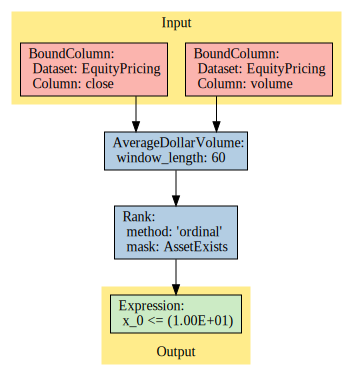

In [4]:
import graphviz

# Render the pipeline as a DAG
pipeline.show_graph()

Right now, our pipeline is empty and it only contains a screen. Therefore, when we rendered our `pipeline`, we only see the diagram of our `screen`:

```python
AverageDollarVolume(window_length = 60).top(10)
```

By default, the `.AverageDollarVolume()` class uses the `USEquityPricing` dataset, containing daily trading prices and volumes, to compute the average dollar volume:

```python
average_dollar_volume = np.nansum(close_price * volume, axis=0) / len(close_price)
```
The top of the diagram reflects the fact that the `.AverageDollarVolume()` class gets its inputs (closing price and volume) from the `USEquityPricing` dataset. The bottom of the diagram shows that the output is determined by the expression `x_0 <= 10`. This expression reflects the fact that we used `.top(10)` as a filter in our `screen`. We refer to each box in the diagram as a Term. 

# Datasets and Dataloaders               

One of the features of Zipline's Pipeline is that it separates the actual source of the stock data from the abstract description of that dataset. Therefore, Zipline employs **DataSets** and **Loaders** for those datasets. `DataSets` are just abstract collections of sentinel values describing the columns/types for a particular dataset.  While a `loader` is an object which, given a request for a particular chunk of a dataset, can actually get the requested data. For example, the loader used for the `USEquityPricing` dataset, is the `USEquityPricingLoader` class. The `USEquityPricingLoader` class will delegate the loading of baselines and adjustments to lower-level subsystems that know how to get the pricing data in the default formats used by Zipline (`bcolz` for pricing data, and `SQLite` for split/merger/dividend data). As we saw in the beginning of this notebook, data bundles automatically convert the stock data into `bcolz` and `SQLite` formats. It is important to note that the `USEquityPricingLoader` class can also be used to load daily OHLCV data from other datasets, not just from the `USEquityPricing` dataset. Simliarly, it is also  possible to write different loaders for the same dataset and use those instead of the default loader. Zipline contains lots of other loaders to allow you to load data from different datasets.

In the code below, we will use `USEquityPricingLoader(BcolzDailyBarWriter, SQLiteAdjustmentWriter)` to create a loader from a `bcolz` equity pricing directory and a `SQLite` adjustments path. Both the `BcolzDailyBarWriter` and `SQLiteAdjustmentWriter` determine the path of the pricing and adjustment data. Since we will be using the Quotemedia data bundle, we will use the `bundle_data.equity_daily_bar_reader` and the `bundle_data.adjustment_reader` as our `BcolzDailyBarWriter` and `SQLiteAdjustmentWriter`, respectively.

In [41]:
from zipline.pipeline.loaders import USEquityPricingLoader

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader,fx_reader=None)

In [68]:
USEquityPricingLoader?

Init signature: USEquityPricingLoader(raw_price_reader, adjustments_reader, fx_reader)
Docstring:     
A PipelineLoader for loading daily OHLCV data.

Parameters
----------
raw_price_reader : zipline.data.session_bars.SessionBarReader
    Reader providing raw prices.
adjustments_reader : zipline.data.adjustments.SQLiteAdjustmentReader
    Reader providing price/volume adjustments.
fx_reader : zipline.data.fx.FXRateReader
   Reader providing currency conversions.
File:           ~/miniconda3/envs/Finance/lib/python3.9/site-packages/zipline/pipeline/loaders/equity_pricing_loader.py
Type:           ImplementsMeta
Subclasses:     

# Pipeline Engine

Zipline employs computation engines for executing Pipelines. In the code below we will use Zipline's `SimplePipelineEngine()` class as the engine to execute our pipeline. The `SimplePipelineEngine(get_loader, calendar, asset_finder)` class associates the chosen data loader with the corresponding dataset and a trading calendar. The `get_loader` parameter must be a callable function that is given a loadable term and returns a `PipelineLoader` to use to retrieve the raw data for that term in the pipeline. In our case, we will be using the `pricing_loader` defined above, we therefore, create a function called `choose_loader` that returns our `pricing_loader`. The function also checks that the data that is being requested corresponds to OHLCV data, otherwise it retunrs an error. The `calendar` parameter must be a `DatetimeIndex` array of dates to consider as trading days when computing a range between a fixed `start_date` and `end_date`. In our case, we will be using the same trading days as those used in the NYSE. We will use Zipline's `get_calendar('NYSE')` function to retrieve the trading days used by the NYSE. We then use the `.all_sessions` attribute to get the `DatetimeIndex` from our `trading_calendar` and pass it to the `calendar` parameter. Finally, the `asset_finder` parameter determines which assets are in the top-level universe of our stock data at any point in time. Since we are using the Quotemedia data bundle, we set this parameter to the `bundle_data.asset_finder`.

In [42]:
import zipline.utils.calendar_utils as utils
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = utils.get_calendar('NYSE')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle_data.asset_finder)

# Running a Pipeline

Once we have chosen our engine we are ready to run or execute our pipeline. We can run our pipeline by using the `.run_pipeline()` attribute of the `SimplePipelineEngine` class. In particular, the `SimplePipelineEngine.run_pipeline(pipeline, start_date, end_date)` implements the following algorithm for executing pipelines:


1. Build a dependency graph of all terms in the `pipeline`. In this step, the graph is sorted topologically to determine the order in which we can compute the terms.


2. Ask our AssetFinder for a “lifetimes matrix”, which should contain, for each date between `start_date` and `end_date`, a boolean value for each known asset indicating whether the asset existed on that date.


3. Compute each term in the dependency order determined in step 1, caching the results in a a dictionary so that they can be fed into future terms.


4. For each date, determine the number of assets passing the `pipeline` screen. The sum, $N$, of all these values is the total number of rows in our output Pandas Dataframe, so we pre-allocate an output array of length $N$ for each factor in terms.


5. Fill in the arrays allocated in step 4 by copying computed values from our output cache into the corresponding rows.


6. Stick the values computed in step 5 into a Pandas DataFrame and return it.

In the code below, we run our pipeline for a single day, so our `start_date` and `end_date` will be the same. We then print some information about our `pipeline_output`.

In [43]:
from zipline.data.bundles import  load

bundle_data = load('eod-quotemedia')
first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day
last_trading_day = bundle_data.equity_daily_bar_reader.last_available_dt

print(f"First trading day: {first_trading_day}")
print(f"Last trading day: {last_trading_day}")

First trading day: 2013-07-01 00:00:00
Last trading day: 2017-06-30 00:00:00


In [44]:
import pandas as pd

# Set the start and end dates
start_date = pd.Timestamp('2016-01-05')
end_date = pd.Timestamp('2016-01-06')


# check if start_date is in sessions

# all_sessions = pipeline.domain(default=US_EQUITIES).sessions().to_list()

# session_in_2016 = [session for session in all_sessions if session >= start_date]
# in the list of all sessions containing the Timestamps filter between start_date and end_date


# Run our pipeline for the given start and end dates
pipeline_output = engine.run_pipeline(pipeline, start_date, end_date)

# We print information about the pipeline output
print('The pipeline output has type:', type(pipeline_output), '\n')

# We print whether the pipeline output is a MultiIndex Dataframe
print('Is the pipeline output a MultiIndex Dataframe:', isinstance(pipeline_output.index, pd.core.index.MultiIndex), '\n')

# If the pipeline output is a MultiIndex Dataframe we print the two levels of the index
if isinstance(pipeline_output.index, pd.core.index.MultiIndex):

    # We print the index level 0
    print('Index Level 0:\n\n', pipeline_output.index.get_level_values(0), '\n')

    # We print the index level 1
    print('Index Level 1:\n\n', pipeline_output.index.get_level_values(1), '\n')

ValueError: Failed to find any assets with country_code 'US' that traded between 2016-01-05 00:00:00 and 2016-01-06 00:00:00.
This probably means that your asset db is old or that it has incorrect country/exchange metadata.

In [33]:
engine.run_pipeline?

Signature: engine.run_pipeline(pipeline, start_date, end_date, hooks=None)
Docstring:
Compute values for ``pipeline`` from ``start_date`` to ``end_date``.

Parameters
----------
pipeline : zipline.pipeline.Pipeline
    The pipeline to run.
start_date : pd.Timestamp
    Start date of the computed matrix.
end_date : pd.Timestamp
    End date of the computed matrix.
hooks : list[implements(PipelineHooks)], optional
    Hooks for instrumenting Pipeline execution.

Returns
-------
result : pd.DataFrame
    A frame of computed results.

    The ``result`` columns correspond to the entries of
    `pipeline.columns`, which should be a dictionary mapping strings to
    instances of :class:`zipline.pipeline.Term`.

    For each date between ``start_date`` and ``end_date``, ``result``
    will contain a row for each asset that passed `pipeline.screen`.
    A screen of ``None`` indicates that a row should be returned for
    each asset that existed each day.
File:      ~/miniconda3/envs/Finance/li

We can see above that the return value of `.run_pipeline()` is a `MultiIndex` Pandas DataFrame containing a row for each asset that passed our pipeline’s screen. We can also see that the 0th level of the index contains the date and the 1st level of the index contains the tickers. In general, the returned Pandas DataFrame will also contain a column for each factor and filter we add to the pipeline using  `Pipeline.add()`. At this point we haven't added any factors or filters to our pipeline, consequently, the Pandas Dataframe will have no columns. In the following sections we will see how to add factors and filters to our pipeline.

# Get Tickers

We saw in the previous section, that the tickers of the stocks that passed our pipeline’s screen are contained in the 1st level of the index. Therefore, we can use the Pandas `.get_level_values(1).values.tolist()` method to get the tickers of those stocks and save them to a list.

In [ ]:
# Get the values in index level 1 and save them to a list
universe_tickers = pipeline_output.index.get_level_values(1).values.tolist()

# Display the tickers
universe_tickers

# Get Data

Now that we have the tickers for the stocks that passed our pipeline’s screen, we can get the historical stock data for those tickers from our data bundle. In order to get the historical data we need to use Zipline's `DataPortal` class. A `DataPortal` is an interface to all of the data that a Zipline simulation needs. In the code below, we will create a `DataPortal` and `get_pricing` function to get historical stock prices for our tickers. 

We have already seen most of the parameters used below when we create the `DataPortal`, so we won't explain them again here. The only new parameter is `first_trading_day`. The `first_trading_day` parameter is a `pd.Timestamp` indicating the first trading day for the simulation. We will set the first trading day to the first trading day in the data bundle. For more information on the `DataPortal` class see the [Zipline documentation](https://www.zipline.io/appendix.html?highlight=dataportal#zipline.data.data_portal.DataPortal)

In [ ]:
from zipline.data.data_portal import DataPortal

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

Now that we have created a `data_portal` we will create a helper function, `get_pricing`, that gets the historical data from the `data_portal` for a given set of `start_date` and `end_date`. The `get_pricing` function takes various parameters: 

```python
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close')
```


The first two parameters, `data_portal` and `trading_calendar`, have already been defined above. The third paramter, `assets`, is a list of tickers. In our case we will use the tickers from the output of our pipeline, namely, `universe_tickers`. The fourth and fifth parameters are strings specifying the `start_date` and `end_date`. The function converts these two strings into Timestamps with a Custom Business Day frequency. The last parameter, `field`, is a string used to indicate which field to return. In our case we want to get the closing price, so we set `field='close`. 

The function returns the historical stock price data using the `.get_history_window()` attribute of the `DataPortal` class. This attribute returns a Pandas Dataframe containing the requested history window with the data fully adjusted. The `bar_count` parameter is an integer indicating the number of days to return. The number of days determines the number of rows of the returned dataframe. Both the `frequency` and `data_frequency` parameters are strings that indicate the frequency of the data to query, *i.e.* whether the data is in `daily` or `minute` intervals.

In [ ]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    end_dt = pd.Timestamp(end_date, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_date, tz='UTC', freq='C')

    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')

# Get the historical data for the given window
historical_data = get_pricing(data_portal, trading_calendar, universe_tickers,
                              start_date='2011-01-05', end_date='2016-01-05')
# Display the historical data
historical_data

# Date Alignment

When pipeline returns with a date of, e.g., `2016-01-07` this includes data that would be known as of before the **market open** on `2016-01-07`. As such, if you ask for latest known values on each day, it will return the closing price from the day before and label the date `2016-01-07`. All factor values assume to be run prior to the open on the labeled day with data known before that point in time.

# Adding Factors and Filters

Now that you know how build a pipeline and execute it, in this section we will see how we can add factors and filters to our pipeline. These factors and filters will determine the computations we want our pipeline to compute each day.

We can add both factors and filters to our pipeline using the `.add(column, name)` method of the `Pipeline` class. The `column` parameter represetns the factor or filter to add to the pipeline. The `name` parameter is a string that determines the name of the column in the output Pandas Dataframe for that factor of fitler. As mentioned earlier, each factor and filter will appear as a column in the output dataframe of our pipeline. Let's start by adding a factor to our pipeline.

### Factors

In the code below, we will use Zipline's built-in `SimpleMovingAverage` factor to create a factor that computes the 15-day mean closing price of securities. We will then add this factor to our pipeline and use `.show_graph()` to see a diagram of our pipeline with the factor added. 

In [ ]:
from zipline.pipeline.factors import SimpleMovingAverage

# Create a factor that computes the 15-day mean closing price of securities
mean_close_15 = SimpleMovingAverage(inputs = [USEquityPricing.close], window_length = 15)

# Add the factor to our pipeline
pipeline.add(mean_close_15, '15 Day MCP')

# Render the pipeline as a DAG
pipeline.show_graph()

In the diagram above we can clearly see the factor we have added. Now, we can run our pipeline again and see its output. The pipeline is run in exactly the same way we did before. 

In [ ]:
# Set starting and end dates
start_date = pd.Timestamp('2014-01-06', tz='utc')
end_date = pd.Timestamp('2016-01-05', tz='utc')

# Run our pipeline for the given start and end dates
output = engine.run_pipeline(pipeline, start_date, end_date)

# Display the pipeline output
output.head()

We can see that now our output dataframe contains a column with the name `15 Day MCP`, which is the name we gave to our factor before. This ouput dataframe from our pipeline gives us the 15-day mean closing price of the securities that passed our `screen`.

### Filters

Filters are created and added to the pipeline in the same way as factors. In the code below, we create a filter that returns `True` whenever the 15-day average closing price is above \$100. Remember, a filter produces a `True` or `False` value for each security every day. We will then add this filter to our pipeline and use `.show_graph()` to see a diagram of our pipeline with the filter added.

In [ ]:
# Create a Filter that returns True whenever the 15-day average closing price is above $100
high_mean = mean_close_15 > 100

# Add the filter to our pipeline
pipeline.add(high_mean, 'High Mean')

# Render the pipeline as a DAG
pipeline.show_graph()

In the diagram above we can clearly see the fiter we have added. Now, we can run our pipeline again and see its output. The pipeline is run in exactly the same way we did before. 

In [ ]:
# Set starting and end dates
start_date = pd.Timestamp('2014-01-06', tz='utc')
end_date = pd.Timestamp('2016-01-05', tz='utc')

# Run our pipeline for the given start and end dates
output = engine.run_pipeline(pipeline, start_date, end_date)

# Display the pipeline output
output.head()

We can see that now our output dataframe contains a two columns, one for the filter and one for the factor. The new column has the name `High Mean`, which is the name we gave to our filter before. Notice that the filter column only contains Boolean values, where only the securities with a 15-day average closing price above \$100 have `True` values.